In [11]:
import pandas as pd
import numpy as np
from sklearn.utils import resample
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# Load your CSV
df = pd.read_csv("./processed_data/merged_cic_andmal2017.csv")

# Map benign and malware labels
benign_labels = ["benign", "malware_2015_1016"]
df['label'] = df['label'].apply(lambda x: 0 if x in benign_labels else x)

# Assign malware classes 1,2,3... based on unique labels
malware_labels = df[df['label'] != 0]['label'].unique()
malware_label_map = {label: idx + 1 for idx, label in enumerate(malware_labels)}
df['label'] = df['label'].apply(lambda x: malware_label_map.get(x, x) if x != 0 else 0)

# Undersample benign samples to 1200
benign_df = df[df['label'] == 0]
benign_sampled = resample(benign_df, replace=False, n_samples=1200, random_state=42)

# Keep malware samples for augmentation
malware_df = df[df['label'] != 0]

print("Benign samples:", len(benign_sampled))
print("Malware class distribution:\n", malware_df['label'].value_counts())

Benign samples: 1200
Malware class distribution:
 label
4    109
3    109
2    101
1     84
Name: count, dtype: int64


In [12]:
# Ensure only numeric columns are used
feature_columns = benign_sampled.select_dtypes(include=[np.number]).columns
feature_columns = [col for col in feature_columns if col != 'label']

# Initialize scalers
benign_scaler = MinMaxScaler(feature_range=(-1, 1))
malware_scaler = MinMaxScaler(feature_range=(-1, 1))

# Extract data and normalize
benign_data = benign_sampled[feature_columns].values
malware_data = malware_df[feature_columns].values

# Fit and transform the data
benign_scaled = benign_scaler.fit_transform(benign_data)
malware_scaled = malware_scaler.fit_transform(malware_data)

# Get counts
n_benign = len(benign_scaled)
n_malware = len(malware_scaled)

# Convert to tensors
benign_tensor = torch.tensor(benign_scaled, dtype=torch.float32)
malware_tensor = torch.tensor(malware_scaled, dtype=torch.float32)

# Balance batch sizes - we'll use the smaller dataset size to determine batch structure
batch_size = 64
n_batches = min(n_benign, n_malware) // batch_size

# Create separate dataloaders
benign_dataset = TensorDataset(benign_tensor)
malware_dataset = TensorDataset(malware_tensor)

benign_loader = DataLoader(benign_dataset, batch_size=batch_size, shuffle=True)
malware_loader = DataLoader(malware_dataset, batch_size=batch_size, shuffle=True)

print(f"DataLoaders created with {n_batches} batches of size {batch_size}")
print(f"Benign samples: {n_benign}")
print(f"Malware samples: {n_malware}")
print(f"Feature dimension: {len(feature_columns)}")

DataLoaders created with 6 batches of size 64
Benign samples: 1200
Malware samples: 403
Feature dimension: 11


In [13]:
class Generator1D(nn.Module):
    def __init__(self, input_dim):
        super(Generator1D, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(128, input_dim),
            nn.Tanh()  # Output in range [-1, 1]
        )

    def forward(self, x):
        return self.model(x)

# Improved Discriminator for 1D tabular data
class Discriminator1D(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator1D, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(128, 64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(64, 32),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

# Dynamically determine input dimension based on the dataset
input_dim = len(feature_columns)

# Initialize models with the correct input dimension
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
G_AB = Generator1D(input_dim=input_dim).to(device)
G_BA = Generator1D(input_dim=input_dim).to(device)
D_A = Discriminator1D(input_dim=input_dim).to(device)
D_B = Discriminator1D(input_dim=input_dim).to(device)

# Loss functions
adversarial_loss = nn.MSELoss()
cycle_loss = nn.L1Loss()

In [14]:
lr = 0.0001  # Reduced learning rate for stability
betas = (0.5, 0.999)
optimizer_G = optim.Adam(list(G_AB.parameters()) + list(G_BA.parameters()), lr=lr, betas=betas)
optimizer_D_A = optim.Adam(D_A.parameters(), lr=lr, betas=betas)
optimizer_D_B = optim.Adam(D_B.parameters(), lr=lr, betas=betas)

# Function to check if tensor has NaN values
def has_nan(tensor):
    return torch.isnan(tensor).any().item()

# Initialize history tracking
loss_history_G = []
loss_history_D_A = []
loss_history_D_B = []

# Training loop
num_epochs = 300  # Reduced number of epochs
lambda_cycle = 10.0  # Cycle consistency weight
clip_value = 1.0    # For gradient clipping

print(f"Starting training on {device}...")
for epoch in range(num_epochs):
    epoch_loss_G = 0
    epoch_loss_D_A = 0
    epoch_loss_D_B = 0
    batches_processed = 0
    
    # Create iterators for the dataloaders
    benign_iter = iter(benign_loader)
    malware_iter = iter(malware_loader)
    
    for i in range(min(len(benign_loader), len(malware_loader))):
        try:
            # Get real data
            real_A = next(benign_iter)[0].to(device)
            real_B = next(malware_iter)[0].to(device)
            
            # Ensure batch sizes match
            min_batch_size = min(real_A.size(0), real_B.size(0))
            real_A = real_A[:min_batch_size]
            real_B = real_B[:min_batch_size]

            # Sanity check for NaN in input data
            if has_nan(real_A) or has_nan(real_B):
                print(f"Found NaN in input data at batch {i}. Skipping...")
                continue

            # Create labels
            valid = torch.ones(min_batch_size, 1).to(device)
            fake = torch.zeros(min_batch_size, 1).to(device)

            # ------------------
            #  Train Generators
            # ------------------
            optimizer_G.zero_grad()

            # Forward translation
            fake_B = G_AB(real_A)
            recov_A = G_BA(fake_B)

            # Backward translation
            fake_A = G_BA(real_B)
            recov_B = G_AB(fake_A)

            # Adversarial losses
            loss_GAN_AB = adversarial_loss(D_B(fake_B), valid)
            loss_GAN_BA = adversarial_loss(D_A(fake_A), valid)
            
            # Cycle consistency losses
            loss_cycle_A = cycle_loss(recov_A, real_A)
            loss_cycle_B = cycle_loss(recov_B, real_B)

            # Total generator loss
            loss_G = loss_GAN_AB + loss_GAN_BA + lambda_cycle * (loss_cycle_A + loss_cycle_B)
            
            # Check for NaN in generator loss
            if has_nan(loss_G):
                print(f"NaN detected in generator loss at epoch {epoch}, batch {i}. Skipping...")
                continue

            loss_G.backward()
            
            # Gradient clipping for stability
            torch.nn.utils.clip_grad_norm_(G_AB.parameters(), clip_value)
            torch.nn.utils.clip_grad_norm_(G_BA.parameters(), clip_value)
            
            optimizer_G.step()

            # -----------------------
            #  Train Discriminator A
            # -----------------------
            optimizer_D_A.zero_grad()
            
            # Real loss
            real_loss_A = adversarial_loss(D_A(real_A), valid)
            
            # Fake loss (with detached generator output)
            fake_loss_A = adversarial_loss(D_A(fake_A.detach()), fake)
            
            # Total discriminator loss
            loss_D_A = (real_loss_A + fake_loss_A) * 0.5
            
            if not has_nan(loss_D_A):
                loss_D_A.backward()
                torch.nn.utils.clip_grad_norm_(D_A.parameters(), clip_value)
                optimizer_D_A.step()

            # -----------------------
            #  Train Discriminator B
            # -----------------------
            optimizer_D_B.zero_grad()
            
            # Real loss
            real_loss_B = adversarial_loss(D_B(real_B), valid)
            
            # Fake loss (with detached generator output)
            fake_loss_B = adversarial_loss(D_B(fake_B.detach()), fake)
            
            # Total discriminator loss
            loss_D_B = (real_loss_B + fake_loss_B) * 0.5
            
            if not has_nan(loss_D_B):
                loss_D_B.backward()
                torch.nn.utils.clip_grad_norm_(D_B.parameters(), clip_value)
                optimizer_D_B.step()
            
            # Track losses (only if not NaN)
            if not (has_nan(loss_G) or has_nan(loss_D_A) or has_nan(loss_D_B)):
                epoch_loss_G += loss_G.item()
                epoch_loss_D_A += loss_D_A.item()
                epoch_loss_D_B += loss_D_B.item()
                batches_processed += 1
            
        except StopIteration:
            break

    # Store average losses for this epoch (avoid division by zero)
    if batches_processed > 0:
        avg_loss_G = epoch_loss_G / batches_processed
        avg_loss_D_A = epoch_loss_D_A / batches_processed
        avg_loss_D_B = epoch_loss_D_B / batches_processed
        
        loss_history_G.append(avg_loss_G)
        loss_history_D_A.append(avg_loss_D_A)
        loss_history_D_B.append(avg_loss_D_B)

        if epoch % 10 == 0:
            print(f"Epoch {epoch}/{num_epochs}: Generator Loss {avg_loss_G:.4f}, D_A Loss {avg_loss_D_A:.4f}, D_B Loss {avg_loss_D_B:.4f}")
    else:
        print(f"Epoch {epoch}/{num_epochs}: No valid batches processed")

Starting training on cuda...
Found NaN in input data at batch 1. Skipping...
Epoch 0/300: Generator Loss 16.6006, D_A Loss 0.2448, D_B Loss 0.2454
Found NaN in input data at batch 1. Skipping...
Found NaN in input data at batch 6. Skipping...
Found NaN in input data at batch 1. Skipping...
Found NaN in input data at batch 3. Skipping...
Found NaN in input data at batch 3. Skipping...
Found NaN in input data at batch 5. Skipping...
Found NaN in input data at batch 5. Skipping...
Found NaN in input data at batch 5. Skipping...
Found NaN in input data at batch 4. Skipping...
Found NaN in input data at batch 1. Skipping...
Epoch 10/300: Generator Loss 9.3590, D_A Loss 0.2131, D_B Loss 0.2174
Found NaN in input data at batch 5. Skipping...
Found NaN in input data at batch 2. Skipping...
Found NaN in input data at batch 6. Skipping...
Found NaN in input data at batch 5. Skipping...
Found NaN in input data at batch 5. Skipping...
Found NaN in input data at batch 5. Skipping...
Found NaN in in

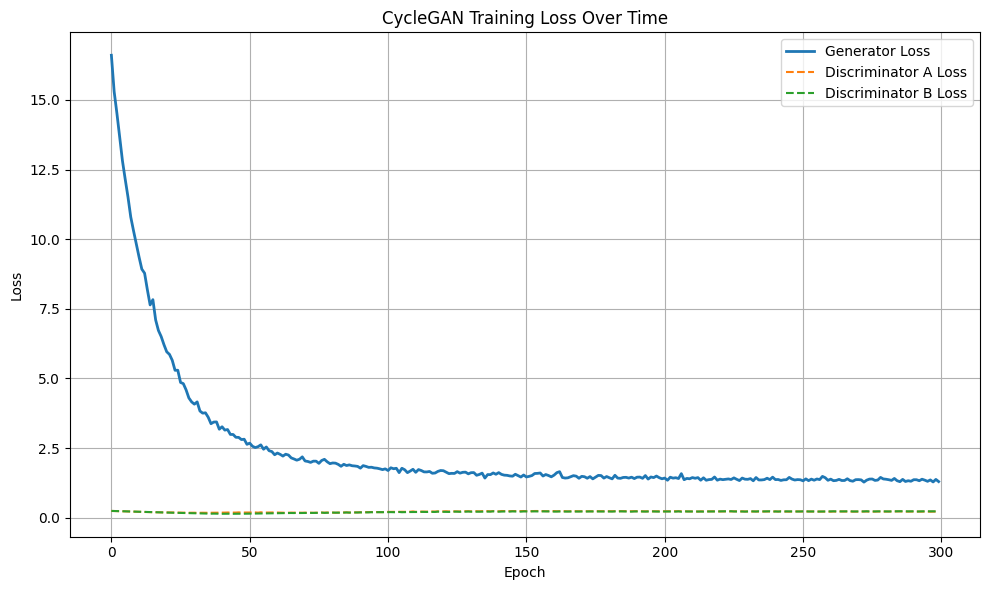

In [15]:
plt.figure(figsize=(10, 6))
plt.plot(loss_history_G, label='Generator Loss', linewidth=2)
plt.plot(loss_history_D_A, label='Discriminator A Loss', linestyle='--')
plt.plot(loss_history_D_B, label='Discriminator B Loss', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('CycleGAN Training Loss Over Time')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('cyclegan_loss_plot.png')
plt.show()

In [16]:
def generate_samples(generator, base_samples, target_count, batch_size=64):
    """
    Generate synthetic samples using the trained generator
    
    Args:
        generator: The trained generator model
        base_samples: Numpy array of base samples to transform
        target_count: Number of samples to generate
        batch_size: Batch size for processing
        
    Returns:
        Numpy array of generated samples
    """
    generated = []
    generator.eval()  # Set to evaluation mode
    
    # Process in batches to prevent memory issues
    with torch.no_grad():
        # First pass: generate from all available base samples
        for i in range(0, len(base_samples), batch_size):
            batch = base_samples[i:i+batch_size]
            base_tensor = torch.tensor(batch, dtype=torch.float32).to(device)
            fake_data = generator(base_tensor).cpu().numpy()
            generated.extend(fake_data)
    
    # If we need more samples than we generated, repeat with sampling
    remaining = target_count - len(generated)
    if remaining > 0:
        # Take what we have so far
        generated_array = np.array(generated)
        
        # Generate additional samples by randomly sampling from what we've generated
        indices = np.random.choice(len(generated), remaining, replace=True)
        additional_base = generated_array[indices]
        
        with torch.no_grad():
            for i in range(0, len(additional_base), batch_size):
                batch = additional_base[i:i+min(batch_size, len(additional_base)-i)]
                base_tensor = torch.tensor(batch, dtype=torch.float32).to(device)
                fake_data = generator(base_tensor).cpu().numpy()
                generated.extend(fake_data[:min(batch_size, remaining)])
                remaining -= min(batch_size, remaining)
                if remaining <= 0:
                    break
    
    return np.array(generated[:target_count])

# Save the trained models
torch.save(G_AB.state_dict(), 'generator_benign_to_malware.pth')
torch.save(G_BA.state_dict(), 'generator_malware_to_benign.pth')
torch.save(D_A.state_dict(), 'discriminator_benign.pth')
torch.save(D_B.state_dict(), 'discriminator_malware.pth')

print("Models saved successfully.")

Models saved successfully.


In [17]:
target_per_class = 1200  # Same as benign samples
balanced_data = []
balanced_labels = []

# Add all benign samples (unscaled original data)
benign_data_original = benign_sampled[feature_columns].values
balanced_data.append(benign_data_original)
balanced_labels.extend([0] * len(benign_sampled))

# Get unique malware classes
malware_classes = sorted(malware_df['label'].unique())

for malware_class in malware_classes:
    # Get real samples for this class
    class_df = malware_df[malware_df['label'] == malware_class]
    class_samples = class_df[feature_columns].values
    class_count = len(class_samples)
    
    print(f"Processing malware class {malware_class}: {class_count} real samples available")
    
    if class_count >= target_per_class:
        # Downsample if we have too many
        selected_idx = np.random.choice(class_count, target_per_class, replace=False)
        balanced_data.append(class_samples[selected_idx])
    else:
        # Use all real samples
        balanced_data.append(class_samples)
        
        # Generate synthetic samples to reach the target
        needed = target_per_class - class_count
        print(f"  Generating {needed} synthetic samples for class {malware_class}")
        
        # Get the scaled version of the samples
        class_samples_scaled = malware_scaler.transform(class_samples)
        
        # Generate in scaled space
        synthetic_samples_scaled = generate_samples(G_AB, benign_scaled, needed)
        
        # Transform back to original space
        synthetic_samples = malware_scaler.inverse_transform(synthetic_samples_scaled)
        
        # Add to balanced data
        balanced_data.append(synthetic_samples)
    
    # Add labels
    balanced_labels.extend([malware_class] * target_per_class)

# Combine all data
all_data = np.vstack(balanced_data)

Processing malware class 1: 84 real samples available
  Generating 1116 synthetic samples for class 1
Processing malware class 2: 101 real samples available
  Generating 1099 synthetic samples for class 2
Processing malware class 3: 109 real samples available
  Generating 1091 synthetic samples for class 3
Processing malware class 4: 109 real samples available
  Generating 1091 synthetic samples for class 4


In [18]:
# Create final dataframe
final_df = pd.DataFrame(all_data, columns=feature_columns)
final_df['label'] = balanced_labels

# Save balanced dataset
final_df.to_csv("balanced_augmented_dataset.csv", index=False)
print(f"Final balanced dataset created with {len(final_df)} samples")
print("Class distribution:")
print(final_df['label'].value_counts())

Final balanced dataset created with 6000 samples
Class distribution:
label
0    1200
1    1200
2    1200
3    1200
4    1200
Name: count, dtype: int64


In [19]:
final_df = pd.DataFrame(all_data, columns=feature_columns)
final_df['label'] = balanced_labels

# Save balanced dataset
final_df.to_csv("balanced_augmented_dataset.csv", index=False)
print(f"Final balanced dataset created with {len(final_df)} samples")
print("Class distribution:")
print(final_df['label'].value_counts())

Final balanced dataset created with 6000 samples
Class distribution:
label
0    1200
1    1200
2    1200
3    1200
4    1200
Name: count, dtype: int64
